In [1]:
from pandas_datareader import data as datareader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime

/anaconda2/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import r2_score, matthews_corrcoef, f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
np.random.seed(0)

# Data reading

In [5]:
data = pd.read_csv('aapl_dataset.csv', index_col = 'Date')

In [6]:
data = data.dropna()

In [7]:
data.tail()

,high,low,open,close,volume,adj close,feat_RSI_close,feat_OBV_volume,feat_ATR_close,feat_HT_DCPERIOD_close,feat_HT_DCPHASE_close,feat_FUNDAMENTAL1_CHG,feat_FUNDAMENTAL2_CHG,feat_K10_FILING,feat_SENTIMENT_UP,feat_DIVIDEND
Date,,,,,,,,,,,,,,,,
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,283.596924,74.436585,2.224292e+10,3.913542,28.454955,150.076370,-0.337975,0.541358,3,0,-0.982111
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,289.223602,78.678994,2.226620e+10,4.041862,28.079039,153.345130,-0.408145,0.929980,0,1,-2.587859
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,289.113831,78.405656,2.222964e+10,4.171015,27.740405,156.893808,0.162783,0.732749,3,1,0.814541
2019-12-30,292.690002,285.220001,289.459991,291.519989,36028600.0,290.829773,79.598963,2.226566e+10,4.406657,27.553361,160.727817,-0.933116,0.980977,0,0,-1.696447
2019-12-31,293.679993,289.519989,289.929993,293.649994,25201400.0,292.954712,80.999258,2.229087e+10,4.389039,27.941882,164.208211,0.383039,0.336035,1,0,0.176790


# Data Preparation

In [8]:
from mlfinlab.features.fracdiff import frac_diff_ffd
from utils import get_meta_barier, getDailyVol

In [9]:
frac_diff_series = frac_diff_ffd(pd.DataFrame(np.log(data['close'])), 0.7, thresh=1e-4)

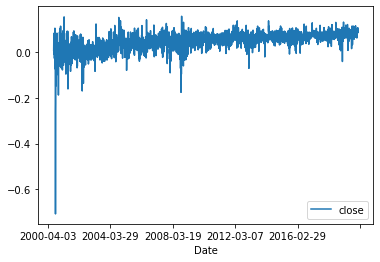

In [10]:
frac_diff_series.plot()

# Feature Extraction

In [11]:
from mlfinlab.microstructural_features import get_roll_measure, get_roll_impact
from mlfinlab.microstructural_features import get_corwin_schultz_estimator, get_bekker_parkinson_vol
from mlfinlab.microstructural_features import get_bar_based_kyle_lambda, get_bar_based_amihud_lambda, get_bar_based_hasbrouck_lambda

In [12]:
WINDOW = 14
INPUT_WINDOW = 14 # REDUCED THE CONTEXT
HORIZON = 1
N_SAMPLES = 10

In [13]:
def create_model():
    # added bagging of decison trees instead of linear models
    clf=RandomForestClassifier(n_estimators=1,
                               criterion='entropy',
                               bootstrap=False,
                               class_weight='balanced_subsample')
    clf=BaggingClassifier(base_estimator=clf,
                         n_estimators=100,
                         max_features=1.)
    return clf

# Feature Definition

In [14]:
data['feat_new_roll_measure'] = get_roll_measure(data['close'], WINDOW)
data['feat_new_roll_impact'] = get_roll_impact(data['close'], data['volume'], WINDOW)
data['feat_new_corwin_schultz'] = get_corwin_schultz_estimator(data['high'], data['low'], WINDOW)
data['feat_new_bekker_parkinson_vol'] = get_bekker_parkinson_vol(data['high'], data['low'], WINDOW)
data['feat_new_kyle_lambda'] = get_bar_based_kyle_lambda(data['close'], data['volume'], WINDOW)
data['feat_new_amihud_lambda'] = get_bar_based_amihud_lambda(data['close'], data['volume'], WINDOW)
data['feat_new_hasbrouck_lambda'] = get_bar_based_hasbrouck_lambda(data['close'], data['volume'], WINDOW)

In [15]:
data['feat_new_min_frac_close'] = frac_diff_series.rolling(WINDOW).min()
data['feat_new_max_frac_close'] = frac_diff_series.rolling(WINDOW).max()
data['feat_new_mean_frac_close'] = frac_diff_series.rolling(WINDOW).mean()
data['feat_new_std_frac_close'] = frac_diff_series.rolling(WINDOW).std()
data['feat_new_skew_frac_close'] = frac_diff_series.rolling(WINDOW).skew()
data['feat_new_kurt_frac_close'] = frac_diff_series.rolling(WINDOW).kurt()
data['feat_new_autocorr_frac_close'] = frac_diff_series.rolling(WINDOW).apply(lambda x: x.autocorr(), raw=False)

In [16]:
FEATURE_COLUMNS = [d for d in data.columns if 'feat_new' in d]

In [17]:
dataset = data[FEATURE_COLUMNS]

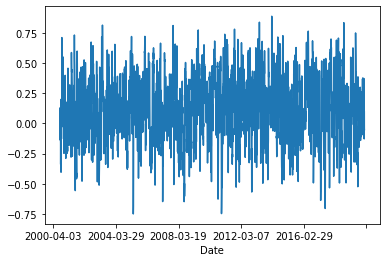

In [18]:
data['feat_new_autocorr_frac_close'].plot()

In [19]:
dataset['close'] = data['close']
dataset = dataset.dropna()

In [20]:
def createXY(inputs, outputs, training=False):   
    X, Y, P = [], [], []
    
    # FIXED IID ASSUMPTION (up to some point)
    if training:
        SKIP = INPUT_WINDOW
    else:
        SKIP = 1
    
    for i in range(INPUT_WINDOW, len(inputs)-HORIZON, SKIP):

        window = inputs[i-INPUT_WINDOW:i].values
        future = (outputs[i+HORIZON] - outputs[i]) / outputs[i]

        X.append(window)
        Y.append(np.sign(future))
        P.append(future)

    X, Y, P = np.array(X), np.array(Y), np.array(P)
    return X, Y, P

In [21]:
# training for longer time!
dataset_train = dataset[:'2017']
dataset_test = dataset['2018':]

In [22]:
# fixed train / test set 
X_train, Y_train, P_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
X_test, Y_test, P_test = createXY(dataset_test[FEATURE_COLUMNS], dataset_test['close'])

# Modeling

In [23]:
# X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
# X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

X_train_flat = X_train.mean(axis=1)
X_test_flat = X_test.mean(axis=1)

In [24]:
mmcs, pred_prs = [], []
for n in range(N_SAMPLES):

    clf = create_model()

    clf.fit(X_train_flat, Y_train)
    pred = clf.predict(X_test_flat)
    pred_pr = clf.predict_proba(X_test_flat)
    
    mmcs.append(matthews_corrcoef(Y_test, pred))
    pred_prs.append(pred_pr)

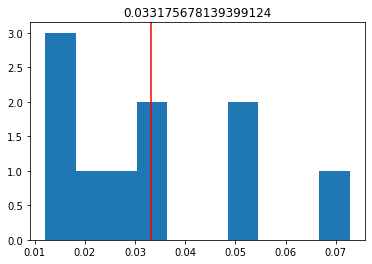

In [25]:
plt.figure()
plt.title(str(np.mean(mmcs)))
plt.hist(mmcs)
plt.axvline(np.mean(mmcs), color = 'red')
plt.show()

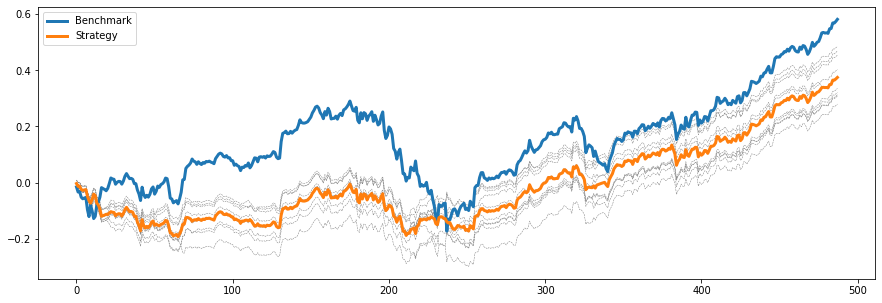

In [26]:
bagging_strategies, bagging_returns = [], []
plt.figure(figsize = (15, 5))

for pred_pr in pred_prs:
    signal = [-p[0] if p[-1] <= 0.5 else p[-1] for p in pred_pr]
    bagging_strategies.append((signal * P_test).cumsum())
    bagging_returns.append(signal * P_test)
    plt.plot((signal * P_test).cumsum(), color = 'grey', ls = '--', lw=0.5)
    
plt.plot(P_test.cumsum(), lw = 3, label = 'Benchmark')
plt.plot(np.array(bagging_strategies).mean(axis=0), lw = 3, label = 'Strategy')

plt.legend()
plt.show()

In [27]:
benchmark_returns = P_test
strategy_returns = np.array(bagging_returns).mean(axis=0)

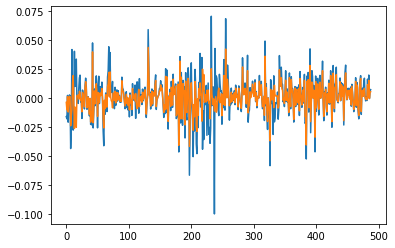

In [28]:
plt.figure()
plt.plot(benchmark_returns)
plt.plot(strategy_returns)
plt.show()

In [29]:
np.mean(benchmark_returns), np.mean(strategy_returns)

(0.0011921322602130005, 0.000767831214389348)

# Evaluation

In [30]:
from mlfinlab.backtest_statistics import sharpe_ratio
from mlfinlab.backtest_statistics import probabilistic_sharpe_ratio
from mlfinlab.backtest_statistics import deflated_sharpe_ratio
from mlfinlab.backtest_statistics import information_ratio
from mlfinlab.backtest_statistics import minimum_track_record_length
from mlfinlab.backtest_statistics import drawdown_and_time_under_water

In [31]:
benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
benchmark_sharpe

1.078471232060782

In [32]:
strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
strategy_sharpe

1.1023234403781792

In [33]:
psr = probabilistic_sharpe_ratio(strategy_sharpe, benchmark_sharpe, len(benchmark_returns))
psr

0.6609855744354498

In [34]:
all_strategy_sharpes = []
for r in bagging_returns:
    sr_i = sharpe_ratio(r, entries_per_year=252)
    all_strategy_sharpes.append(sr_i)

dsr = deflated_sharpe_ratio(strategy_sharpe, all_strategy_sharpes, len(benchmark_returns))
dsr

1.0

In [35]:
ir = information_ratio(strategy_returns, benchmark=np.mean(benchmark_returns), entries_per_year=252)
ir

-0.609140368121607

In [36]:
mtrl = minimum_track_record_length(strategy_sharpe, benchmark_sharpe)
mtrl

7645.764439777516

# Checking Feature Importance

In [37]:
import shap
from sklearn.ensemble import RandomForestClassifier

In [38]:
# fixed train / test set 
X_train, Y_train, P_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
X_test, Y_test, P_test = createXY(dataset_test[FEATURE_COLUMNS], dataset_test['close'])

In [39]:
X_train_df = pd.DataFrame(X_train.mean(axis=1), columns = FEATURE_COLUMNS)
X_test_df = pd.DataFrame(X_test.mean(axis=1), columns = FEATURE_COLUMNS)

In [40]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', criterion='entropy')
clf.fit(X_train_df, Y_train)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_df)

fi0 = np.abs(shap_values[0]).mean(axis=0)
fi1 = np.abs(shap_values[1]).mean(axis=0)
fi = fi0 + fi1
imp = pd.DataFrame({
    'feature': X_train_df.columns.tolist(),
    'mean': fi
})
imp = imp.set_index('feature')

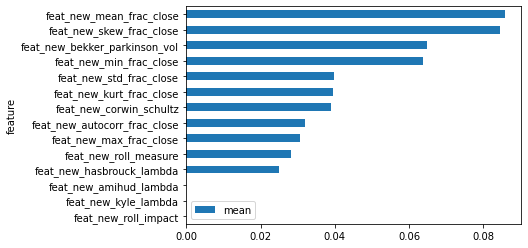

In [41]:
imp.sort_values('mean').plot.barh()

In [42]:
# IMPORTANT_FEATURES = imp.sort_values('mean')[::-1][:-4].index.values.tolist()
IMPORTANT_FEATURES = imp[imp['mean'] > 0].index.values.tolist()
# IMPORTANT_FEATURES = FEATURE_COLUMNS

In [43]:
IMPORTANT_FEATURES

['feat_new_roll_measure',
 'feat_new_corwin_schultz',
 'feat_new_bekker_parkinson_vol',
 'feat_new_hasbrouck_lambda',
 'feat_new_min_frac_close',
 'feat_new_max_frac_close',
 'feat_new_mean_frac_close',
 'feat_new_std_frac_close',
 'feat_new_skew_frac_close',
 'feat_new_kurt_frac_close',
 'feat_new_autocorr_frac_close']

# Retraining on the best features

In [44]:
X_train, Y_train, P_train = createXY(dataset_train[IMPORTANT_FEATURES], dataset_train['close'], training=True)
X_test, Y_test, P_test = createXY(dataset_test[IMPORTANT_FEATURES], dataset_test['close'])

In [45]:
# X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
# X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

X_train_flat = X_train.mean(axis=1)
X_test_flat = X_test.mean(axis=1)

In [46]:
mmcs, pred_prs = [], []
for n in range(N_SAMPLES):

    clf = create_model()

    clf.fit(X_train_flat, Y_train)
    pred = clf.predict(X_test_flat)
    pred_pr = clf.predict_proba(X_test_flat)
    
    mmcs.append(matthews_corrcoef(Y_test, pred))
    pred_prs.append(pred_pr)

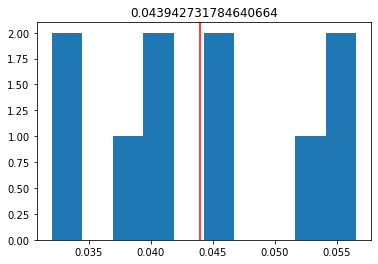

In [47]:
plt.figure()
plt.title(str(np.mean(mmcs)))
plt.hist(mmcs)
plt.axvline(np.mean(mmcs), color = 'red')
plt.show()

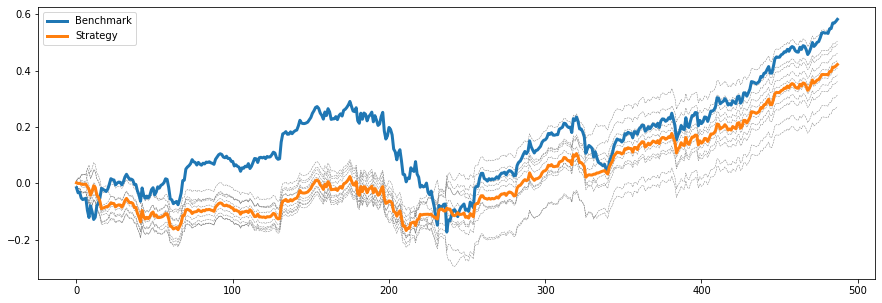

In [48]:
bagging_strategies, bagging_returns = [], []

plt.figure(figsize = (15, 5))

for pred_pr in pred_prs:
    signal = [-p[0] if p[-1] <= 0.5 else p[-1] for p in pred_pr]
    bagging_strategies.append((signal * P_test).cumsum())
    bagging_returns.append(signal * P_test)
    plt.plot((signal * P_test).cumsum(), color = 'grey', ls = '--', lw=0.5)
    
plt.plot(P_test.cumsum(), lw = 3, label = 'Benchmark')
plt.plot(np.array(bagging_strategies).mean(axis=0), lw = 3, label = 'Strategy')

plt.legend()
plt.show()

In [49]:
strategy_returns_features = np.array(bagging_returns).mean(axis=0)

In [50]:
benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
benchmark_sharpe

1.078471232060782

In [51]:
strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
strategy_sharpe

1.1023234403781792

In [52]:
strategy_sharpe_features = sharpe_ratio(strategy_returns_features, entries_per_year=252)
strategy_sharpe_features

1.2600560046532938

In [53]:
psr = probabilistic_sharpe_ratio(strategy_sharpe_features, strategy_sharpe, len(benchmark_returns))
psr

0.99532390826828